<a href="https://colab.research.google.com/github/rpjena/random_matrix/blob/main/cumsumcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

class CUSUMRegimeDetector:
    """
    CUSUM-based regime detection for PnL returns analysis
    Implements both exponential weighting and rolling window methods
    """

    def __init__(self, returns: pd.Series):
        """
        Initialize with PnL returns

        Parameters:
        -----------
        returns : pd.Series
            Time series of PnL returns
        """
        self.returns = returns.dropna()
        self.results = {}

    def calculate_cusum_statistics(self, target_mean: float = None,
                                 std_dev: float = None) -> Dict:
        """
        Calculate basic CUSUM statistics

        Parameters:
        -----------
        target_mean : float, optional
            Target mean for CUSUM (default: sample mean)
        std_dev : float, optional
            Standard deviation for normalization (default: sample std)
        """
        if target_mean is None:
            target_mean = self.returns.mean()
        if std_dev is None:
            std_dev = self.returns.std()

        # Standardized returns
        standardized = (self.returns - target_mean) / std_dev

        # CUSUM calculations
        cusum_pos = np.maximum.accumulate(np.maximum(0,
                    np.cumsum(standardized)))
        cusum_neg = np.minimum.accumulate(np.minimum(0,
                    np.cumsum(standardized)))

        return {
            'standardized_returns': standardized,
            'cusum_positive': cusum_pos,
            'cusum_negative': cusum_neg,
            'target_mean': target_mean,
            'std_dev': std_dev
        }

    def rolling_cusum(self, window: int = 252, threshold: float = 2.0) -> Dict:
        """
        Rolling window CUSUM implementation

        Parameters:
        -----------
        window : int
            Rolling window size (default: 252 for 1 year)
        threshold : float
            Threshold for regime change detection
        """
        rolling_stats = self.returns.rolling(window=window)
        rolling_mean = rolling_stats.mean()
        rolling_std = rolling_stats.std()

        # Initialize arrays
        n = len(self.returns)
        cusum_pos = np.zeros(n)
        cusum_neg = np.zeros(n)
        regime_changes = np.zeros(n, dtype=bool)

        for i in range(window, n):
            # Get rolling statistics
            mu = rolling_mean.iloc[i]
            sigma = rolling_std.iloc[i]

            if pd.isna(mu) or pd.isna(sigma) or sigma == 0:
                continue

            # Standardized return
            z_score = (self.returns.iloc[i] - mu) / sigma

            # Update CUSUM
            cusum_pos[i] = max(0, cusum_pos[i-1] + z_score - threshold/2)
            cusum_neg[i] = min(0, cusum_neg[i-1] + z_score + threshold/2)

            # Check for regime change
            if abs(cusum_pos[i]) > threshold or abs(cusum_neg[i]) > threshold:
                regime_changes[i] = True
                cusum_pos[i] = 0  # Reset after detection
                cusum_neg[i] = 0

        return {
            'cusum_positive': cusum_pos,
            'cusum_negative': cusum_neg,
            'regime_changes': regime_changes,
            'rolling_mean': rolling_mean,
            'rolling_std': rolling_std,
            'threshold': threshold,
            'window': window
        }

    def exponential_cusum(self, alpha: float = 0.05, threshold: float = 2.0) -> Dict:
        """
        Exponentially weighted CUSUM implementation

        Parameters:
        -----------
        alpha : float
            Smoothing parameter (0 < alpha < 1)
        threshold : float
            Threshold for regime change detection
        """
        n = len(self.returns)

        # Initialize exponentially weighted statistics
        ewm_mean = np.zeros(n)
        ewm_var = np.zeros(n)
        cusum_pos = np.zeros(n)
        cusum_neg = np.zeros(n)
        regime_changes = np.zeros(n, dtype=bool)

        # Initialize first values
        ewm_mean[0] = self.returns.iloc[0]
        ewm_var[0] = 0

        for i in range(1, n):
            # Update exponentially weighted mean and variance
            ewm_mean[i] = alpha * self.returns.iloc[i] + (1 - alpha) * ewm_mean[i-1]
            diff = self.returns.iloc[i] - ewm_mean[i-1]
            ewm_var[i] = alpha * diff**2 + (1 - alpha) * ewm_var[i-1]

            # Avoid division by zero
            ewm_std = np.sqrt(ewm_var[i]) if ewm_var[i] > 0 else 1e-8

            # Standardized return
            z_score = (self.returns.iloc[i] - ewm_mean[i-1]) / ewm_std

            # Update CUSUM
            cusum_pos[i] = max(0, cusum_pos[i-1] + z_score - threshold/2)
            cusum_neg[i] = min(0, cusum_neg[i-1] + z_score + threshold/2)

            # Check for regime change
            if abs(cusum_pos[i]) > threshold or abs(cusum_neg[i]) > threshold:
                regime_changes[i] = True
                cusum_pos[i] = 0  # Reset after detection
                cusum_neg[i] = 0

        return {
            'cusum_positive': cusum_pos,
            'cusum_negative': cusum_neg,
            'regime_changes': regime_changes,
            'ewm_mean': ewm_mean,
            'ewm_std': np.sqrt(ewm_var),
            'threshold': threshold,
            'alpha': alpha
        }

    def sensitivity_analysis(self, thresholds: List[float] = None,
                           method: str = 'rolling', **kwargs) -> pd.DataFrame:
        """
        Analyze sensitivity to different threshold levels

        Parameters:
        -----------
        thresholds : List[float]
            List of threshold values to test
        method : str
            'rolling' or 'exponential'
        **kwargs : additional parameters for the chosen method
        """
        if thresholds is None:
            thresholds = np.arange(0.5, 4.1, 0.25)

        sensitivity_results = []

        for threshold in thresholds:
            if method == 'rolling':
                result = self.rolling_cusum(threshold=threshold, **kwargs)
            else:
                result = self.exponential_cusum(threshold=threshold, **kwargs)

            n_changes = np.sum(result['regime_changes'])
            change_rate = n_changes / len(self.returns)

            # Calculate metrics
            if n_changes > 0:
                change_indices = np.where(result['regime_changes'])[0]
                avg_time_between = np.mean(np.diff(change_indices)) if len(change_indices) > 1 else len(self.returns)
            else:
                avg_time_between = len(self.returns)

            sensitivity_results.append({
                'threshold': threshold,
                'n_regime_changes': n_changes,
                'change_rate': change_rate,
                'avg_time_between_changes': avg_time_between
            })

        return pd.DataFrame(sensitivity_results)

    def performance_metrics(self, regime_changes: np.ndarray) -> Dict:
        """
        Calculate performance metrics around regime changes
        """
        change_indices = np.where(regime_changes)[0]

        if len(change_indices) == 0:
            return {'n_changes': 0}

        # Pre and post change performance
        pre_change_perf = []
        post_change_perf = []
        window = 20  # Days around change

        for idx in change_indices:
            if idx >= window and idx + window < len(self.returns):
                pre_perf = self.returns.iloc[idx-window:idx].mean()
                post_perf = self.returns.iloc[idx:idx+window].mean()
                pre_change_perf.append(pre_perf)
                post_change_perf.append(post_perf)

        return {
            'n_changes': len(change_indices),
            'change_dates': self.returns.index[change_indices].tolist(),
            'pre_change_avg_return': np.mean(pre_change_perf) if pre_change_perf else 0,
            'post_change_avg_return': np.mean(post_change_perf) if post_change_perf else 0,
            'performance_shift': np.mean(post_change_perf) - np.mean(pre_change_perf) if pre_change_perf and post_change_perf else 0
        }

    def plot_analysis(self, figsize: Tuple[int, int] = (15, 12)):
        """
        Create comprehensive visualization of CUSUM analysis
        """
        # Run both methods
        rolling_result = self.rolling_cusum()
        exp_result = self.exponential_cusum()

        # Sensitivity analysis
        rolling_sensitivity = self.sensitivity_analysis(method='rolling')
        exp_sensitivity = self.sensitivity_analysis(method='exponential')

        fig, axes = plt.subplots(3, 2, figsize=figsize)
        fig.suptitle('CUSUM Regime Detection Analysis', fontsize=16, fontweight='bold')

        # Plot 1: Returns and regime changes (Rolling)
        ax1 = axes[0, 0]
        ax1.plot(self.returns.index, self.returns.values, alpha=0.7, color='blue', label='Returns')
        change_dates = self.returns.index[rolling_result['regime_changes']]
        if len(change_dates) > 0:
            ax1.scatter(change_dates, self.returns.loc[change_dates],
                       color='red', s=50, zorder=5, label='Regime Changes')
        ax1.set_title('PnL Returns - Rolling CUSUM')
        ax1.set_ylabel('Returns')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Returns and regime changes (Exponential)
        ax2 = axes[0, 1]
        ax2.plot(self.returns.index, self.returns.values, alpha=0.7, color='blue', label='Returns')
        change_dates_exp = self.returns.index[exp_result['regime_changes']]
        if len(change_dates_exp) > 0:
            ax2.scatter(change_dates_exp, self.returns.loc[change_dates_exp],
                       color='red', s=50, zorder=5, label='Regime Changes')
        ax2.set_title('PnL Returns - Exponential CUSUM')
        ax2.set_ylabel('Returns')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: CUSUM statistics (Rolling)
        ax3 = axes[1, 0]
        ax3.plot(self.returns.index, rolling_result['cusum_positive'],
                label='CUSUM+', color='green')
        ax3.plot(self.returns.index, rolling_result['cusum_negative'],
                label='CUSUM-', color='red')
        ax3.axhline(y=rolling_result['threshold'], color='orange',
                   linestyle='--', label=f"Threshold ({rolling_result['threshold']})")
        ax3.axhline(y=-rolling_result['threshold'], color='orange', linestyle='--')
        ax3.set_title('Rolling CUSUM Statistics')
        ax3.set_ylabel('CUSUM Value')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: CUSUM statistics (Exponential)
        ax4 = axes[1, 1]
        ax4.plot(self.returns.index, exp_result['cusum_positive'],
                label='CUSUM+', color='green')
        ax4.plot(self.returns.index, exp_result['cusum_negative'],
                label='CUSUM-', color='red')
        ax4.axhline(y=exp_result['threshold'], color='orange',
                   linestyle='--', label=f"Threshold ({exp_result['threshold']})")
        ax4.axhline(y=-exp_result['threshold'], color='orange', linestyle='--')
        ax4.set_title('Exponential CUSUM Statistics')
        ax4.set_ylabel('CUSUM Value')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # Plot 5: Sensitivity Analysis - Number of Changes
        ax5 = axes[2, 0]
        ax5.plot(rolling_sensitivity['threshold'], rolling_sensitivity['n_regime_changes'],
                'o-', label='Rolling', color='blue')
        ax5.plot(exp_sensitivity['threshold'], exp_sensitivity['n_regime_changes'],
                's-', label='Exponential', color='red')
        ax5.set_title('Sensitivity: Number of Regime Changes')
        ax5.set_xlabel('Threshold')
        ax5.set_ylabel('Number of Changes')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Plot 6: Sensitivity Analysis - Change Rate
        ax6 = axes[2, 1]
        ax6.plot(rolling_sensitivity['threshold'], rolling_sensitivity['change_rate'],
                'o-', label='Rolling', color='blue')
        ax6.plot(exp_sensitivity['threshold'], exp_sensitivity['change_rate'],
                's-', label='Exponential', color='red')
        ax6.set_title('Sensitivity: Regime Change Rate')
        ax6.set_xlabel('Threshold')
        ax6.set_ylabel('Change Rate')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Performance metrics
        rolling_metrics = self.performance_metrics(rolling_result['regime_changes'])
        exp_metrics = self.performance_metrics(exp_result['regime_changes'])

        print("\n" + "="*50)
        print("CUSUM REGIME DETECTION SUMMARY")
        print("="*50)

        print(f"\nROLLING METHOD (Window: {rolling_result['window']}):")
        print(f"  Number of regime changes: {rolling_metrics['n_changes']}")
        if rolling_metrics['n_changes'] > 0:
            print(f"  Pre-change avg return: {rolling_metrics['pre_change_avg_return']:.4f}")
            print(f"  Post-change avg return: {rolling_metrics['post_change_avg_return']:.4f}")
            print(f"  Performance shift: {rolling_metrics['performance_shift']:.4f}")

        print(f"\nEXPONENTIAL METHOD (Alpha: {exp_result['alpha']}):")
        print(f"  Number of regime changes: {exp_metrics['n_changes']}")
        if exp_metrics['n_changes'] > 0:
            print(f"  Pre-change avg return: {exp_metrics['pre_change_avg_return']:.4f}")
            print(f"  Post-change avg return: {exp_metrics['post_change_avg_return']:.4f}")
            print(f"  Performance shift: {exp_metrics['performance_shift']:.4f}")

        return {
            'rolling_result': rolling_result,
            'exponential_result': exp_result,
            'rolling_metrics': rolling_metrics,
            'exponential_metrics': exp_metrics,
            'rolling_sensitivity': rolling_sensitivity,
            'exponential_sensitivity': exp_sensitivity
        }

# Example usage and demonstration
def generate_sample_data(n_periods: int = 1000) -> pd.Series:
    """Generate sample PnL returns with regime changes"""
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', periods=n_periods, freq='D')

    # Create returns with regime changes
    returns = []
    regimes = [
        (0, 300, 0.0005, 0.015),      # Low vol, positive drift
        (300, 600, -0.001, 0.025),    # Higher vol, negative drift
        (600, 800, 0.002, 0.012),     # Low vol, high positive drift
        (800, 1000, 0.0002, 0.020)   # Medium vol, low drift
    ]

    for start, end, mean_return, volatility in regimes:
        n = end - start
        regime_returns = np.random.normal(mean_return, volatility, n)
        returns.extend(regime_returns)

    return pd.Series(returns, index=dates, name='PnL_Returns')


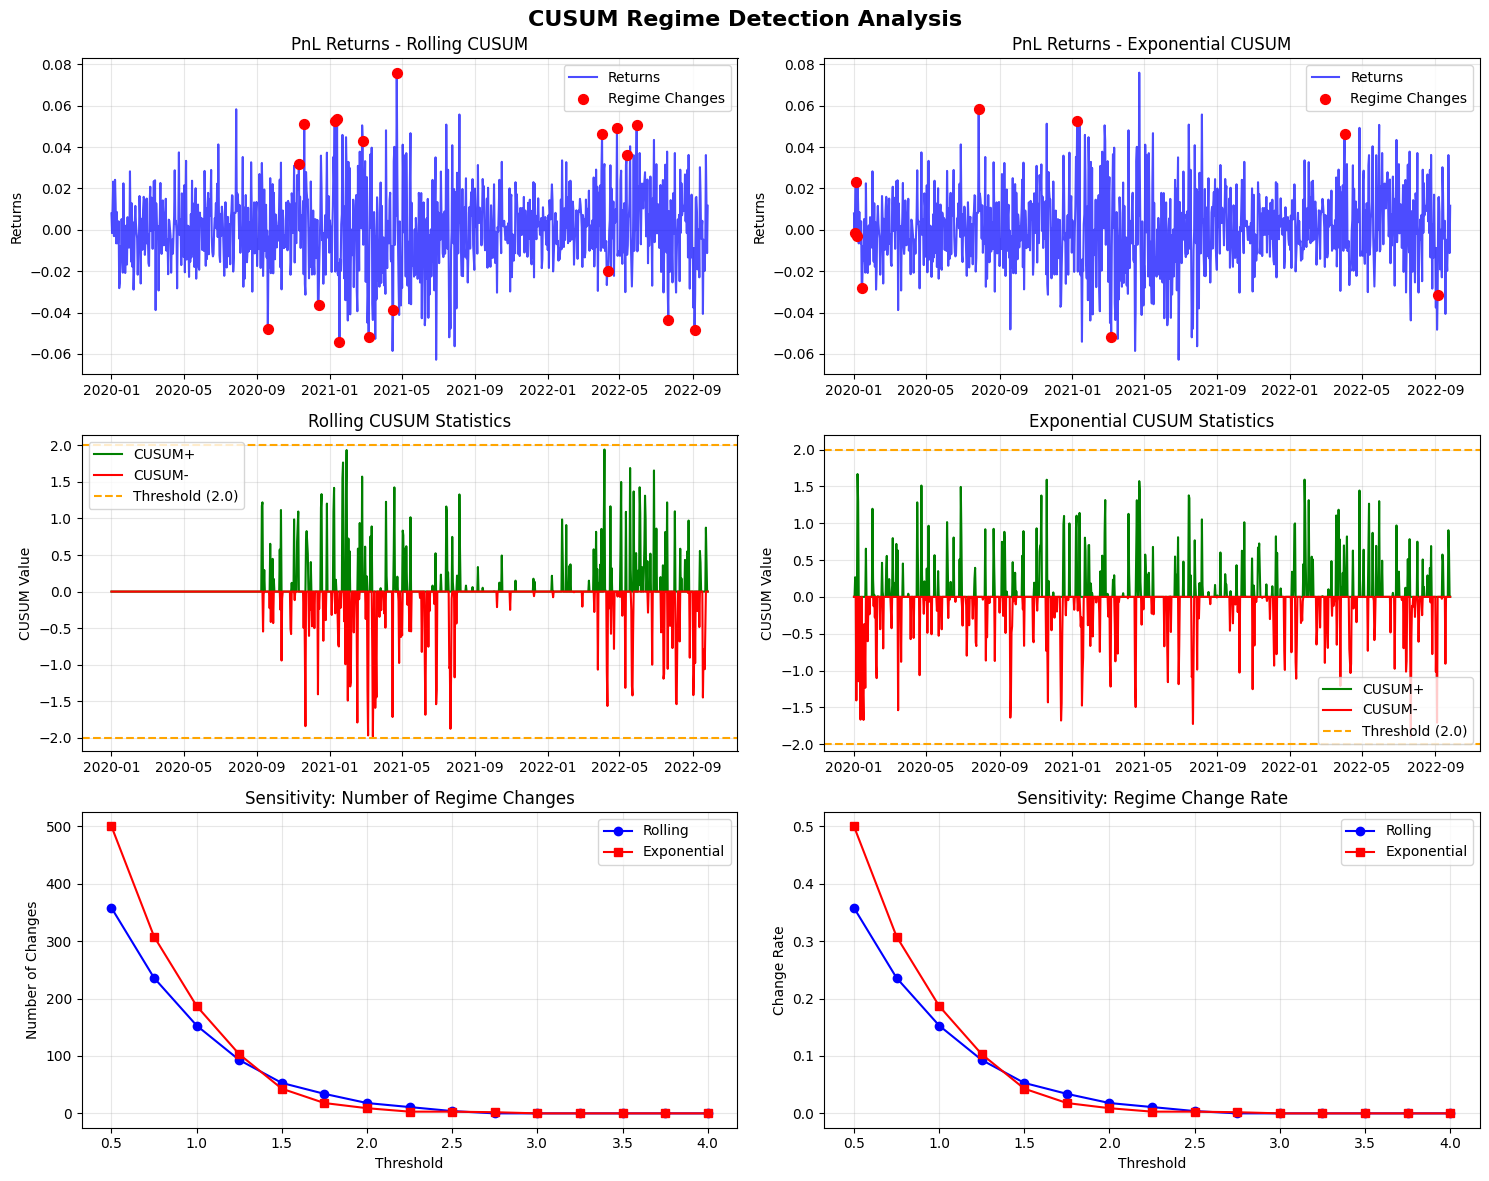


CUSUM REGIME DETECTION SUMMARY

ROLLING METHOD (Window: 252):
  Number of regime changes: 18
  Pre-change avg return: 0.0024
  Post-change avg return: 0.0005
  Performance shift: -0.0019

EXPONENTIAL METHOD (Alpha: 0.05):
  Number of regime changes: 9
  Pre-change avg return: 0.0022
  Post-change avg return: -0.0006
  Performance shift: -0.0028

DETAILED SENSITIVITY ANALYSIS

Rolling Method Results:
------------------------------
Threshold 1.0: 153 regime changes
Threshold 1.5: 53 regime changes
Threshold 2.0: 18 regime changes
Threshold 2.5:  4 regime changes
Threshold 3.0:  0 regime changes

Exponential Method Results:
------------------------------
Threshold 1.0: 187 regime changes
Threshold 1.5: 43 regime changes
Threshold 2.0:  9 regime changes
Threshold 2.5:  3 regime changes
Threshold 3.0:  0 regime changes


In [2]:

# Generate sample data
sample_returns = generate_sample_data()

# Initialize detector
detector = CUSUMRegimeDetector(sample_returns)

# Run comprehensive analysis
results = detector.plot_analysis()

# Additional sensitivity analysis with custom thresholds
print(f"\n{'='*50}")
print("DETAILED SENSITIVITY ANALYSIS")
print(f"{'='*50}")

thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]

print("\nRolling Method Results:")
print("-" * 30)
for threshold in thresholds:
    result = detector.rolling_cusum(threshold=threshold)
    n_changes = np.sum(result['regime_changes'])
    print(f"Threshold {threshold:3.1f}: {n_changes:2d} regime changes")

print("\nExponential Method Results:")
print("-" * 30)
for threshold in thresholds:
    result = detector.exponential_cusum(threshold=threshold)
    n_changes = np.sum(result['regime_changes'])
    print(f"Threshold {threshold:3.1f}: {n_changes:2d} regime changes")